# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [3]:
# Visualizations will be shown in the notebook.
%matplotlib inline

import os
from datetime import datetime 
import collections
import random
import pickle
from collections import Counter
import operator


import math

import numpy as np
from numpy import genfromtxt
import numpy.ma as ma
import pandas as pd

import tensorflow as tf
from tensorflow.python.tools.inspect_checkpoint import print_tensors_in_checkpoint_file


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import shuffle
from skimage import exposure

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import ImageGrid


import cv2

from PIL import Image

helper functions
- show_image(image, cmap=None)
- load_pickle(filename, directory='.')
- list_to_numpy(list_data)
- make_indexer(labels)
- slice_few_image(data, indexer, cutoff=200)
- make_fake_images(images_list, labels_list, copy_no=10)
- get_random_image(data, label)
- get_random_images(data, label, sample_no = 89)
- convert_gray_with_adapthist(X, y = None)
- transform_image_test(img,ang_range,shear_range,trans_range)
- split_data(data, label, split = 0.3)
- load_resized_images_in_directory(width,height,dirname)
- resize_image(image, width, height)
- load_images_in_directory

In [4]:
def show_image(image, cmap=None):
    
    if(cmap == 'gray'):
        plt.figure(figsize=(5,5))
        plt.imshow(image, cmap='gray')
    
    else:
        plt.figure(figsize=(5,5))
        plt.imshow(image)
        
def load_pickle(filename, directory='.'):   
    with open(filename, 'rb') as f:
         data = pickle.load(f)
    return data

            
def list_to_numpy(list_data):
    
    return np.array(list_data)


def make_indexer(labels):
    
    indexer = []
    new_data = [] 
    new_labels = []
    
    x = collections.Counter(labels)

    value = 0

    for k, v in sorted(x.items()):
#        print(k)
#        print(v)
        value += v
        indexer.append(value)
        
    return indexer

def slice_few_image(data, indexer, cutoff=200):
     
    new_data = [] 
    new_labels = []

    for i in range (len(indexer)-1):
        
        if(i ==0 and (indexer[0] < cutoff)):
            
            for step in range(indexer[0]):
                new_labels.append(i)
                new_data.append(data[step])
        
        if(indexer[i+1] - indexer[i] < cutoff):
            
            for step in range(indexer[i+1] - indexer[i]):
            
                new_labels.append(i+1)
                new_data.append(data[indexer[i]+step])
                   
    return new_data, new_labels

def make_fake_images(images_list, labels_list, copy_no=10):
    
    X_train_fake = []
    y_train_fake = []
    copy_no = copy_no
    
    for copy in range(copy_no):
        for index, image in  enumerate(images_list):
            image = transform_image_test(image,10,5,5)
            image =  image.reshape(image.shape + (1,)) 
            X_train_fake.append(image)
            y_train_fake.append(labels_list[index])
    return X_train_fake, y_train_fake



def get_random_image(data, label):
   
    random_size = len(data)
    
    maybe_image = random.randint(0,random_size)
          
    return data[maybe_image]

def get_random_images(data, label, sample_no = 89):
    
    sample_locs = []
    sample_labels = []
    
    images = []
    
    for i in range(sample_no):
        
        image =  get_random_image(data, label)
        images.append(image)
        
    return images


def convert_gray_with_adapthist(X, y = None):
    #Convert to grayscale, e.g. single Y channel
    X = 0.299 * X[:, :, :, 0] + 0.587 * X[:, :, :, 1] + 0.114 * X[:, :, :, 2]
    #Scale features to be in [0, 1]
    X = (X / 255.).astype(np.float32)
    
 
      
    # Apply localized histogram localization  
    for i in range(X.shape[0]):
        X[i] = exposure.equalize_adapthist(X[i])
        
    print("y is %s" % y)
        
    if y is not None:  
        # Convert to one-hot encoding. Convert back with `y = y.nonzero()[1]`
        y = np.eye(43)[y]
        # Shuffle the data
        X, y = shuffle(X, y)

    # Add a single grayscale channel
    X = X.reshape(X.shape + (1,)) 
    return X, y

def transform_image_test(img,ang_range,shear_range,trans_range):
    '''
    This function transforms images to generate new images.
    The function takes in following arguments,
    1- Image
    2- ang_range: Range of angles for rotation
    3- shear_range: Range of values to apply affine transform to
    4- trans_range: Range of values to apply translations over. 
    
    A Random uniform distribution is used to generate different parameters for transformation
    
    '''
    # Rotation

    ang_rot = np.random.uniform(ang_range)-ang_range/2
    rows,cols,ch = img.shape    
    Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2),ang_rot,1)

    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    tr_y = trans_range*np.random.uniform()-trans_range/2
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])

    # Shear
    pts1 = np.float32([[5,5],[20,5],[5,20]])

    pt1 = 5+shear_range*np.random.uniform()-shear_range/2
    pt2 = 20+shear_range*np.random.uniform()-shear_range/2
    
    # Brightness 
    
    pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])

    shear_M = cv2.getAffineTransform(pts1,pts2)
        
    img = cv2.warpAffine(img,Rot_M,(cols,rows))
    img = cv2.warpAffine(img,Trans_M,(cols,rows))
    img = cv2.warpAffine(img,shear_M,(cols,rows))
    
#    img = augment_brightness_camera_images(img)
    
    return img


def split_data(data, label, split = 0.3):
    
    X_train, X_valid, y_train, y_valid = train_test_split(
    data,
    label,
    test_size=split,
    random_state=832289)
    
    return X_train, X_valid, y_train, y_valid





def load_resized_images_in_directory(width,height,dirname):
    
    image_list = os.listdir(dirname)

    y_data = np.array(image_list)
    y_data2 = np.char.rstrip(y_data,'.jpg')
    y_web = y_data2.astype(np.uint8)
    
    X_web = np.array([cv2.resize(np.array(mpimg.imread(imagedir + fname)),(32,32)) 
                  for fname in image_list])
    
    return X_web, y_web
    

def resize_image(image, width, height):
    
    return cv2.resize(np.array(image),(width,height))

def load_images_in_directory(dirname):
    
    image_list = os.listdir(dirname)

    y_data = np.array(image_list)
    y_data2 = np.char.rstrip(y_data,'.jpg')
    y_web = y_data2.astype(np.uint8)

#    print(y_train[:5])

#    print(y_web[:])
    
    X_web = np.array([mpimg.imread(imagedir + fname) for fname in image_list])
    
    return X_web, y_web

In [5]:
X_train_original = load_pickle('train.p')
data = X_train_original['features']
X_train_gray,_ = convert_gray_with_adapthist(data)

/root/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float32 to uint16
  "%s to %s" % (dtypeobj_in, dtypeobj))


y is None


In [6]:
y_train_gray = X_train_original['labels']
print(y_train_gray[10])

0


In [7]:
test = load_pickle('test.p')
data_test = test['features']
y_test = test['labels']

X_test,_ = convert_gray_with_adapthist(data_test)

/root/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float32 to uint16
  "%s to %s" % (dtypeobj_in, dtypeobj))


y is None


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [8]:
#### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# TODO: Number of training examples
n_train = len(data)

# TODO: Number of testing examples.
n_test = len(data_test)

# TODO: What's the shape of an traffic sign image?
image_shape = data.shape[1:4]

# TODO: How many unique classes/labels there are in the dataset.
n_classes = np.unique(X_train_original['labels']).size

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("number of classes ", n_classes)
#print("coords_train =", coords_train)
#print("size_train =", size_train)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
number of classes  43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

In [9]:
traffic_signs = pd.read_csv("signnames.csv")
traffic_signs

,ClassId,SignName
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)
5,5,Speed limit (80km/h)
6,6,End of speed limit (80km/h)
7,7,Speed limit (100km/h)
8,8,Speed limit (120km/h)
9,9,No passing


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f50cf826e80>]], dtype=object)

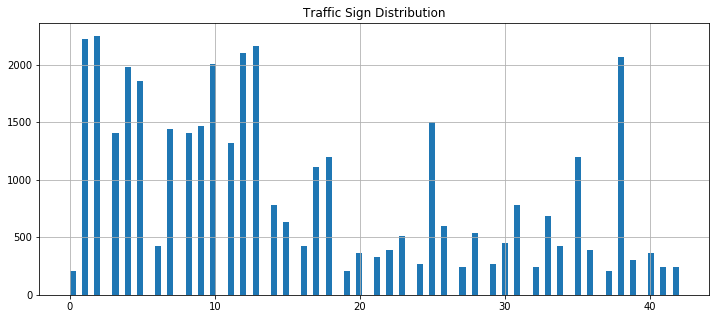

In [10]:
distribution =pd.DataFrame({"Traffic Sign Distribution":X_train_original['labels']})
distribution.hist(layout=(1,1),bins=100, figsize=(12,5))  

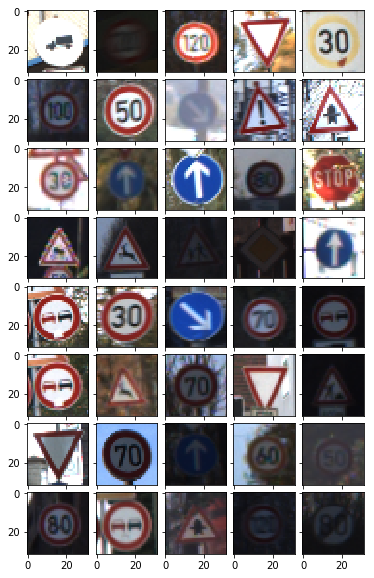

[]
[]


In [11]:
sample_locs = []
sample_labels = []
random_size = n_train

fig = plt.figure(1, (10., 10.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(8, 5),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                  )

for i in range(40):
    maybe_image = get_random_image(X_train_original['features'],X_train_original['labels'])
#    grid[i].imshow(maybe_image) 
#    X_normalized = normalize_grayscale(maybe_image, scale=0.6)
    grid[i].imshow(maybe_image) 
     # The AxesGrid object work as a list of axes.

plt.show()

print(sample_locs)
print(sample_labels)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

1. shuffling
2. gray conversion
3. LeNet-5 architecture from the course
4. model layer evaluation (run each model whenever layer is added.)

### Pre-process the Data Set (normalization, grayscale, etc.)

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

implemented during 'exploratory visualization of the dataset' above 
: def normalize_grayscale(image_data, scale=1)

data normalization(convert to gray) and fake data generation.

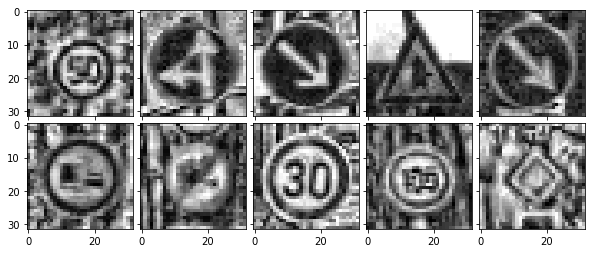

In [12]:
random_size = 10

fig = plt.figure(1, (10., 10.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 5),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                  )

for i in range(random_size):
    maybe_image = get_random_image(X_train_gray,y_train_gray)
    gray = maybe_image.reshape(32,32)
    grid[i].imshow(gray,cmap="gray") 
     
plt.show()

In [13]:
test_indexer = make_indexer(y_train_gray)
#test_data , test_label =  slice_few_image(data, test_indexer, cutoff=400)
test_data , test_label =  slice_few_image(X_train_gray, test_indexer, cutoff=400)

In [14]:
fake_images, fake_labels = make_fake_images(test_data,test_label,copy_no=5)
X_train_fake = list_to_numpy(fake_images)
y_train_fake = list_to_numpy(fake_labels)

In [15]:
print(fake_images[0].shape)
print(fake_labels[0])

(32, 32, 1)
0


In [16]:
print(len(fake_images))
print(len(fake_labels))
print(len(X_train_gray))
print(len(y_train_gray))

21300
21300
39209
39209


In [17]:
X_train_original_fake = np.concatenate((X_train_gray, X_train_fake), axis=0)
y_train_original_fake = np.concatenate((y_train_gray, y_train_fake), axis=0)

print(X_train_original_fake.shape)
print(y_train_original_fake.shape)

(60509, 32, 32, 1)
(60509,)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f50c9374c18>]], dtype=object)

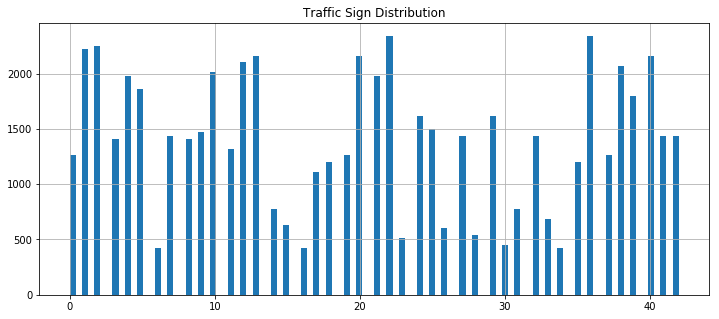

In [18]:
distribution =pd.DataFrame({"Traffic Sign Distribution":y_train_original_fake})
distribution.hist(layout=(1,1),bins=100, figsize=(12,5))  

In [19]:
test_indexer_second = make_indexer(y_train_original_fake)
#test_data , test_label =  slice_few_image(data, test_indexer, cutoff=400)
test_data_second , test_label_second =  slice_few_image(X_train_original_fake, test_indexer_second, cutoff=1000)

In [20]:
fake_images_second, fake_labels_second = make_fake_images(test_data_second,test_label_second,copy_no=3)
X_train_fake_second = list_to_numpy(fake_images_second)
y_train_fake_second = list_to_numpy(fake_labels_second)

In [21]:
print(len(fake_images_second))
print(len(fake_labels_second))
print(len(X_train_original_fake))
print(len(y_train_original_fake))

18717
18717
60509
60509


In [22]:
X_train_original_fake_second = np.concatenate((X_train_original_fake, X_train_fake_second), axis=0)
y_train_original_fake_second = np.concatenate((y_train_original_fake, y_train_fake_second), axis=0)

print(X_train_original_fake_second.shape)
print(y_train_original_fake_second.shape)

(79226, 32, 32, 1)
(79226,)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f50c8fd67b8>]], dtype=object)

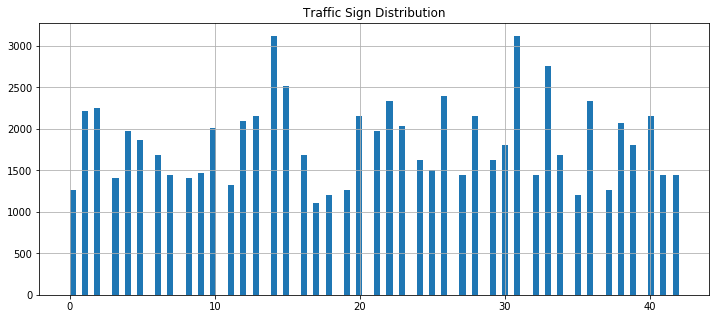

In [23]:
distribution =pd.DataFrame({"Traffic Sign Distribution":y_train_original_fake_second})
distribution.hist(layout=(1,1),bins=100, figsize=(12,5))  

data split and data shuffling.

In [24]:
X_train_plus, X_valid_plus, y_train_plus, y_valid_plus = split_data(X_train_original_fake_second,y_train_original_fake_second,split = 0.3)

In [25]:
X_train_plus, y_train_plus = shuffle(X_train_plus,y_train_plus) 
X_test, y_test = shuffle(X_test, y_test) 

In [41]:
X_train_plus, X_valid_plus, y_train_plus, y_valid_plus = split_data(X_train_original_fake,y_train_original_fake,split = 0.3)

In [42]:
X_train_plus, y_train_plus = shuffle(X_train_plus,y_train_plus) 
X_test, y_test = shuffle(X_test, y_test) 

### Model Architecture

In [26]:
tf.reset_default_graph()
print(len([n.name for n in tf.get_default_graph().as_graph_def().node]))

0


In [27]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

from tensorflow.contrib.layers import flatten

def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    keep_prob = 0.6
    keep_prob_fc = 0.7
    
    
    # SOLUTION: Layer 1: Convolutional. Input = 32x32x1. Output = 32x32x16.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 1, 16), mean = mu, stddev = sigma),name="w1")
    conv1_b = tf.Variable(tf.zeros(16),name="b1")
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='SAME') + conv1_b

    # SOLUTION: Activation.
    conv1_relu = tf.nn.relu(conv1)
    conv1_drop = tf.nn.dropout(conv1_relu, keep_prob)

    # SOLUTION: Pooling. Input = 32x32x16. Output = 16x16x16.
    conv1_pool = tf.nn.max_pool(conv1_drop, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    # SOLUTION: Layer 2: Convolutional. Input = 16x16x16. Output = 16x16x32.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 16, 32), mean = mu, stddev = sigma),name="w2")
    conv2_b = tf.Variable(tf.zeros(32),name="b2")
    conv2   = tf.nn.conv2d(conv1_pool, conv2_W, strides=[1, 1, 1, 1], padding='SAME') + conv2_b
    
    # SOLUTION: Activation.
    conv2_relu = tf.nn.relu(conv2)
    conv2_drop = tf.nn.dropout(conv2_relu, keep_prob)

    # SOLUTION: Pooling. Input = 16x16x16. Output = 8x8x32.
    conv2_pool = tf.nn.max_pool(conv2_drop, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    # SOLUTION: Flatten. Input = 16x16x16. Input = 8x8x32. Output = 6144.
    #    fc0   = flatten(conv2_pool)
    
    conv1_pool_flat = tf.reshape( conv1_pool, [-1, 16 * 16 * 16])
    conv2_pool_flat = tf.reshape( conv2_pool, [-1, 8 * 8 * 32])
    fc0 = tf.concat(1,[ conv1_pool_flat , conv2_pool_flat])
    
    
    # SOLUTION: Layer 3: Fully Connected. Input = 6144. Output = 1200.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(6144, 1200), mean = mu, stddev = sigma),name="fc1_w1")
    fc1_b = tf.Variable(tf.zeros(1200),name="fc1_b1")
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b

    # SOLUTION: Activation.
    fc1_relu    = tf.nn.relu(fc1)
    fc1_drop = tf.nn.dropout(fc1_relu, keep_prob_fc)
    
    # SOLUTION: Layer 4: Fully Connected. Input = 1200. Output = 43.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(1200, 43), mean = mu, stddev = sigma),name="fc2_w2")
  
    fc2_b  = tf.Variable(tf.zeros(43),name="fc2_b2")
    logits  = tf.matmul(  fc1_drop, fc2_W) + fc2_b


    return logits

In [28]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

In [29]:
rate = 0.001

logits = LeNet(x)

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(tf.nn.l2_normalize(logits, dim=0), one_hot_y)
#loss_operation = tf.reduce_mean(tf.nn.l2_loss(cross_entropy))
loss_operation = tf.reduce_mean((cross_entropy))

#defining training operation and debugging functions
optimizer = tf.train.AdamOptimizer(learning_rate = rate)

training_operation = optimizer.minimize(loss_operation)
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
topk_operation = tf.nn.top_k(tf.nn.softmax(logits), k=5)
y_value = tf.argmax(one_hot_y, 1)


tf.summary.scalar("loss", loss_operation)
# Create a summary to monitor accuracy tensor
tf.summary.scalar("accuracy", accuracy_operation)
# Merge all summaries into a single op
merged_summary_op = tf.summary.merge_all()

In [30]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.

EPOCHS = 5
BATCH_SIZE = 128

# hyper parameters to be remained.

# Initializing the variables
init = tf.global_variables_initializer()

# Calling tf.train.Saver
saver = tf.train.Saver()

In [31]:
# defining evaluation function 

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    total_loss = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        loss, accuracy = sess.run([loss_operation, accuracy_operation], feed_dict={x: batch_x, y: batch_y})
        
#       print(loss)
        total_loss += loss
        total_accuracy += (accuracy * len(batch_x))
    return total_loss  , total_accuracy / num_examples

def evaluate_topk(X_data, y_data):
    num_examples = len(X_data)
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        topk_values, topk_indices = sess.run(topk_operation, feed_dict={x: batch_x, y: batch_y})
       
    return topk_values, topk_indices 


def evaluate_debugging(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    total_loss = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        loss_val, acc_val, top_k = sess.run([loss_operation,correct_prediction,topk_operation], feed_dict={x: batch_x, y: batch_y})
        
#       print(loss)
#        total_loss += loss
#        total_accuracy += (accuracy * len(batch_x))
    return loss_val, acc_val, top_k,batch_x, batch_y

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the test set but low accuracy on the validation set implies overfitting.

In [46]:
# trainning and saving trained model

debugger_images = []
debugger_labels = []

train_logs_path = 'tmp/train'
valid_logs_path = 'tmp/valid'
test_logs_path = 'tmp/test'

EPOCHS = 50

with tf.Session() as sess:
    sess.run(init)
    train_writer = tf.summary.FileWriter(train_logs_path, graph=tf.get_default_graph())
    valid_writer = tf.summary.FileWriter(valid_logs_path, graph=tf.get_default_graph())
    test_writer = tf.summary.FileWriter(test_logs_path, graph=tf.get_default_graph())
    
    num_examples = len(X_train_plus)
    
    print("Training...")
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train_plus, y_train_plus)
        
       
        
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            _,loss, accuracy, summary = sess.run([training_operation, loss_operation, accuracy_operation, merged_summary_op], feed_dict={x: batch_x, y: batch_y})
            
            
            summary_writer.add_summary(summary,i+1)
#            summary_writer.flush()
            
        print("EPOCH {} ...".format(i+1))
        print("Train Loss = {:.3f}".format(loss))
        print("Train Accuracy = {:.3f}".format(accuracy))
             
#        print("EPOCH {} ...".format(i+1))
#        validation_loss, validation_accuracy = evaluate(X_valid_plus, y_valid_plus)
       
#        print("Validation loss = {0:.3f}".format(validation_loss))
#        print("Validation Accuracy = {0:.3f}".format(validation_accuracy))
        
#        if(i == (EPOCHS-1) ):
        if((i+1) % 10 == 0 or i == (EPOCHS-1) ):
        
           
            num_examples = len(X_valid_plus)
            X_valid, y_valid = shuffle(X_valid_plus, y_valid_plus)
            for offset in range(0, num_examples, BATCH_SIZE):
                end = offset + BATCH_SIZE
                batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            
                loss, accuracy = sess.run([loss_operation, accuracy_operation], feed_dict={x: batch_x, y: batch_y})
 
                valid_writer.add_summary(summary,i+1)
#            test_loss,test_accuracy = evaluate(X_test, y_test)
          
            print("EPOCH {} ...".format(i+1))
            print("Validation Loss = {:.3f}".format(loss))
            print("Validation Accuracy = {:.3f}".format(accuracy))
#            print("Test Loss = {:.3f}".format(test_loss))
#            print("Test Accuracy = {:.3f}".format(test_accuracy)
        if(i == (EPOCHS-1) ):
           
            num_examples = len(X_test)
            X_test, y_test = shuffle(X_test, y_test)
            for offset in range(0, num_examples, BATCH_SIZE):
                end = offset + BATCH_SIZE
                batch_x, batch_y = X_test[offset:end], y_test[offset:end]
            
                loss, accuracy = sess.run([loss_operation, accuracy_operation], feed_dict={x: batch_x, y: batch_y})
        
                test_writer.add_summary(summary,i+1)
        
            print("EPOCH {} ...".format(i+1))
            print("Test Loss = {:.3f}".format(loss))
            print("Test Accuracy = {:.3f}".format(accuracy))
        
    saver.save(sess, "./lenet/model.ckpt")
#    tf.train.export_meta_graph(filename='./lenet/model.meta')
   
    print("Model saved")

Training...
EPOCH 1 ...
Train Loss = 3.379
Train Accuracy = 0.922
EPOCH 2 ...
Train Loss = 3.308
Train Accuracy = 0.940
EPOCH 3 ...
Train Loss = 3.297
Train Accuracy = 0.948
EPOCH 4 ...
Train Loss = 3.258
Train Accuracy = 0.991
EPOCH 5 ...
Train Loss = 3.277
Train Accuracy = 0.957
EPOCH 6 ...
Train Loss = 3.237
Train Accuracy = 0.983
EPOCH 7 ...
Train Loss = 3.252
Train Accuracy = 1.000
EPOCH 8 ...
Train Loss = 3.239
Train Accuracy = 1.000
EPOCH 9 ...
Train Loss = 3.255
Train Accuracy = 0.983
EPOCH 10 ...
Train Loss = 3.227
Train Accuracy = 0.991
EPOCH 10 ...
Validation Loss = 3.255
Validation Accuracy = 1.000
EPOCH 11 ...
Train Loss = 3.261
Train Accuracy = 1.000
EPOCH 12 ...
Train Loss = 3.269
Train Accuracy = 1.000
EPOCH 13 ...
Train Loss = 3.268
Train Accuracy = 1.000
EPOCH 14 ...
Train Loss = 3.247
Train Accuracy = 1.000
EPOCH 15 ...
Train Loss = 3.269
Train Accuracy = 1.000
EPOCH 16 ...
Train Loss = 3.257
Train Accuracy = 1.000
EPOCH 17 ...
Train Loss = 3.243
Train Accuracy = 1.0

In [47]:
print(len([n.name for n in tf.get_default_graph().as_graph_def().node]))
no_node_training = [n.name for n in tf.get_default_graph().as_graph_def().node]

613


In [48]:
print_tensors_in_checkpoint_file("./lenet/model.ckpt",tensor_name='')
#print_tensors_in_checkpoint_file(file_name='./lenet/model.ckpt', tensor_name='w1')

b1 (DT_FLOAT) [16]
b1/Adam (DT_FLOAT) [16]
b1/Adam_1 (DT_FLOAT) [16]
b2 (DT_FLOAT) [32]
b2/Adam (DT_FLOAT) [32]
b2/Adam_1 (DT_FLOAT) [32]
beta1_power (DT_FLOAT) []
beta2_power (DT_FLOAT) []
fc1_b1 (DT_FLOAT) [1200]
fc1_b1/Adam (DT_FLOAT) [1200]
fc1_b1/Adam_1 (DT_FLOAT) [1200]
fc1_w1 (DT_FLOAT) [6144,1200]
fc1_w1/Adam (DT_FLOAT) [6144,1200]
fc1_w1/Adam_1 (DT_FLOAT) [6144,1200]
fc2_b2 (DT_FLOAT) [43]
fc2_b2/Adam (DT_FLOAT) [43]
fc2_b2/Adam_1 (DT_FLOAT) [43]
fc2_w2 (DT_FLOAT) [1200,43]
fc2_w2/Adam (DT_FLOAT) [1200,43]
fc2_w2/Adam_1 (DT_FLOAT) [1200,43]
w1 (DT_FLOAT) [3,3,1,16]
w1/Adam (DT_FLOAT) [3,3,1,16]
w1/Adam_1 (DT_FLOAT) [3,3,1,16]
w2 (DT_FLOAT) [3,3,16,32]
w2/Adam (DT_FLOAT) [3,3,16,32]
w2/Adam_1 (DT_FLOAT) [3,3,16,32]



---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

[11  2 38 15 40]


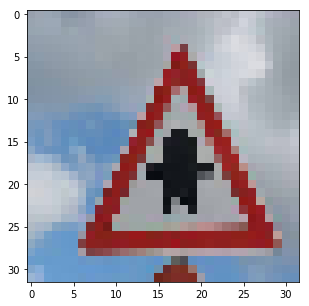

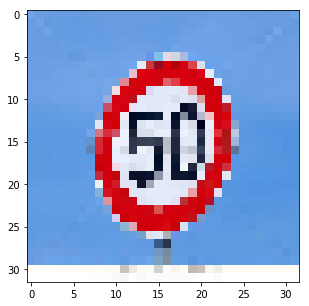

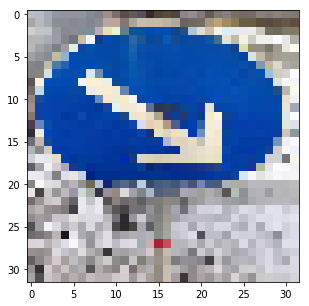

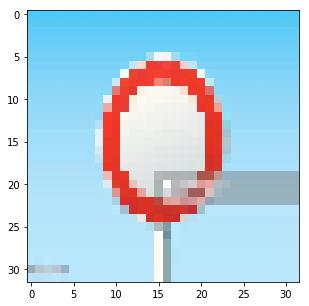

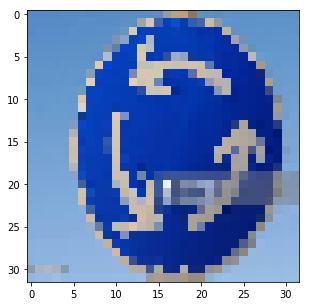

In [49]:
imagedir = "./data/"

X_web,y_web = load_resized_images_in_directory(32,32,imagedir)

print(y_web)

show_image(X_web[0])
show_image(X_web[1])
show_image(X_web[2])
show_image(X_web[3])
show_image(X_web[4])

### Predict the Sign Type for Each Image

### Analyze Performance

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tk.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [50]:
imagedir = "./data/"

data_web,y_web = load_resized_images_in_directory(32,32,imagedir)

In [51]:
X_web,_ = convert_gray_with_adapthist(data_web)

y is None


/root/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float32 to uint16
  "%s to %s" % (dtypeobj_in, dtypeobj))


In [53]:
# restoring and (trainning and saving trained model) again

EPOCHS_WEB = 1


with tf.Session() as sess:
    sess.run(init)
    
    saver.restore(sess, "./lenet/model.ckpt")
       
    print("restored...")
    
    num_examples = len(X_web)
    
    for i in range(EPOCHS_WEB):

        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_web[offset:end], y_web[offset:end]
            print(batch_y)

        if(i == (EPOCHS_WEB-1) ):
            test_loss, test_accuracy = evaluate(X_web, y_web)
          
            print("EPOCH {} ...".format(i+1))
            print("Test Accuracy = {:.3f}".format(test_accuracy))
            
            topk_values, topk_indices = evaluate_topk(X_web, y_web)
            print(topk_values)
            print(topk_indices)


restored...
[11  2 38 15 40]
EPOCH 1 ...
Test Accuracy = 0.600
[[ 0.91588819  0.00521871  0.00446392  0.00239545  0.00220237]
 [ 0.4243829   0.05722466  0.03526757  0.02229865  0.01424   ]
 [ 0.32367954  0.08165368  0.03183318  0.0182748   0.01622326]
 [ 0.06564392  0.02966857  0.02584988  0.02566662  0.02538078]
 [ 0.09870461  0.05210906  0.03687142  0.02432634  0.02348358]]
[[11 30 27 20 21]
 [ 2  5  8  7  0]
 [12 13  2 11 20]
 [34  5 20  2 40]
 [40 13  7 10 20]]


> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the IPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In [54]:
no_node_web = [n.name for n in tf.get_default_graph().as_graph_def().node]

In [55]:
#len([i for i, j in zip( no_node_training, no_node_debugger) if i == j])
len([i for i, j in zip( no_node_training, no_node_web) if i == j])

613

In [ ]:
# STOP: Do not change the tests below. Your implementation should pass these tests. 
#assert X_train.shape == data['features'].shape, 'X_train has changed shape. The shape shouldn\'t change when shuffling.'
#assert y_train.shape == data['labels'].shape, 'y_train has changed shape. The shape shouldn\'t change when shuffling.'

assert round(X_valid.shape[0]/n_train,2) == 0.2, 'X_train not splitted'
assert round(y_valid.shape[0]/n_train,2) == 0.2, 'y_train not splitted'
assert not np.array_equal(X_train, data['features']), 'X_train not shuffled.'
assert not np.array_equal(y_train, data['labels']), 'y_train not shuffled.'
print('Tests passed.')

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 